In [1]:
##We need to add our "imports" file to make sure we have everything
%matplotlib inline
import re
import requests
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly as py
import seaborn as sbn
import textatistic
from bs4 import BeautifulSoup
matplotlib.style.use('ggplot')
import psycopg2
py.offline.init_notebook_mode()

In [5]:
##I decided to use Professor's dataframe just to be sure I was starting from the right spot for this new assignment.
##Read in the dataframe
new_cat = pd.read_json('/home/faculty/millbr02/pub/course_data.json')
new_cat['dept'] = new_cat.dept.map(lambda x : x[:-1])
new_cat.head()

dept                                        description  \
0           accounting  A course specifically for students who have ha...   
1           accounting  The course provides a basic understanding of f...   
10          accounting                                                      
100  athletic-training  This course will provide instruction, practice...   
101  athletic-training                                                      

    gened             hours     number                             prereq  \
0    None           2 hours  ACCTG 110  [First-year or sophomore st, ing]   
1    None           4 hours  ACCTG 150                        [ACCTG 110]   
10   None  1, 2, or 4 hours  ACCTG 485                                 []   
100  None           2 hours  ATHTR 468        [ATHTR 465, senior st, ing]   
101  None  1, 2, or 4 hours  ATHTR 490                                 []   

                                 title  
0           Introduction to Accounting  
1           Fundamentals of Accounting  
10                             Seminar  
100  Clinical VI: Advanced Health Care  
101                     Senior Project

In [6]:
##Add a whole column just for the class abbreviation so we can access it easier
new_cat['dept_code'] = new_cat.number.map(lambda x : x.split(' ')[0])
new_cat.head()

dept                                        description  \
0           accounting  A course specifically for students who have ha...   
1           accounting  The course provides a basic understanding of f...   
10          accounting                                                      
100  athletic-training  This course will provide instruction, practice...   
101  athletic-training                                                      

    gened             hours     number                             prereq  \
0    None           2 hours  ACCTG 110  [First-year or sophomore st, ing]   
1    None           4 hours  ACCTG 150                        [ACCTG 110]   
10   None  1, 2, or 4 hours  ACCTG 485                                 []   
100  None           2 hours  ATHTR 468        [ATHTR 465, senior st, ing]   
101  None  1, 2, or 4 hours  ATHTR 490                                 []   

                                 title dept_code  
0           Introduction to Accounting     ACCTG  
1           Fundamentals of Accounting     ACCTG  
10                             Seminar     ACCTG  
100  Clinical VI: Advanced Health Care     ATHTR  
101                     Senior Project     ATHTR

In [7]:
##Create a list of the abbreviations/codes
codes = set(list(new_cat.dept_code))

In [8]:
##We need to find the prereq classes for each class, use REGEX to find the codes for these classes. *look on REGEX website from CS160*
##Once we find the classes we need to add the abbreviations to the dataframe
def find_prereq(x):
    prereq = []
    for item in x:
        y = item.split(' ')
        for word in y:
            if word in codes:
                prereq.append(word)
    return prereq

new_cat['prereq_code'] = new_cat.prereq.map(lambda x: find_prereq(x))
new_cat['prereq_course'] = new_cat.prereq.map(lambda x: re.findall(r'[A-Z]+ [0-9]+', str(x)))
new_cat.head()

dept                                        description  \
0           accounting  A course specifically for students who have ha...   
1           accounting  The course provides a basic understanding of f...   
10          accounting                                                      
100  athletic-training  This course will provide instruction, practice...   
101  athletic-training                                                      

    gened             hours     number                             prereq  \
0    None           2 hours  ACCTG 110  [First-year or sophomore st, ing]   
1    None           4 hours  ACCTG 150                        [ACCTG 110]   
10   None  1, 2, or 4 hours  ACCTG 485                                 []   
100  None           2 hours  ATHTR 468        [ATHTR 465, senior st, ing]   
101  None  1, 2, or 4 hours  ATHTR 490                                 []   

                                 title dept_code prereq_code prereq_course  
0           Introduction to Accounting     ACCTG          []            []  
1           Fundamentals of Accounting     ACCTG     [ACCTG]   [ACCTG 110]  
10                             Seminar     ACCTG          []            []  
100  Clinical VI: Advanced Health Care     ATHTR     [ATHTR]   [ATHTR 465]  
101                     Senior Project     ATHTR          []            []

In [10]:
##Ask Michael for help
##Make lists of all the codes, and then be prepared to move them around. 
dept_code = list(new_cat.dept_code)
prereq_code = list(new_cat.prereq_code)

dept_code2 = []
prereq_course = []
prereq_code2 = []

major_place = 0
prereq_place = 0
for item in new_cat.prereq_course:
    course_place = 0
    for course in item:
        if len(item) > 1 and len(item) == len(prereq_code[prereq_place]):
            dept_code2.append(dept_code[major_place])
            prereq_code2.append(prereq_code[prereq_place][course_place])
            prereq_course.append(course)
            course_place += 1
        elif len(item) == 1 and len(prereq_code[prereq_place]) == 1:
            dept_code2.append(dept_code[major_place])
            prereq_code2.append(prereq_code[prereq_place][course_place])
            prereq_course.append(course)
            course_place += 1
    
    if len(item) == 0 and len(prereq_code[prereq_place]) > 0:
        for code in prereq_code[prereq_place]:
            dept_code2.append(dept_code[major_place])
            prereq_code2.append(code)
            prereq_course.append('')
        
    major_place += 1
    prereq_place += 1
    
##Print all new lists to make sure everything matches up    
print(len(dept_code2))
print(len(prereq_code2))
print(len(prereq_course))

703
703
703


In [12]:
##Make a smaller dataframe with just these three things from above...department code, prereq code, and prereq class

df_info = {'dept_code': dept_code2, 
        'prereq_code': prereq_code2,
       'prereq_course': prereq_course}

small_df = pd.DataFrame(df_info,columns=['dept_code','prereq_code','prereq_course'])
small_df = small_df.drop_duplicates()
small_df.head(10)

dept_code prereq_code prereq_course
0      ACCTG       ACCTG     ACCTG 110
1      ATHTR       ATHTR     ATHTR 465
2        BIO         BIO       BIO 151
4        BIO         BIO       BIO 152
5        BIO        CHEM      CHEM 152
6        BIO        CHEM      CHEM 201
7        BIO        PHYS      PHYS 152
27      AFRS        PAID      PAID 111
34       BIO         BIO       BIO 248
37       BIO         BIO       BIO 255

In [15]:
##We need to find classes that arnt prereqs but are classes in the department.
majors = []
prereqs = []
amount_majors = 0
amount_prereqs = 0

for i in range(len(dept_code2)):
    if dept_code2[i] != prereq_code2[i]:
        majors.append(dept_code2[i])
        prereqs.append(prereq_code2[i])
    amount_majors += 1
    amount_prereqs += 1
##just comparing the two

##check to see if they match again
print(len(majors))
print(len(prereqs))

208
208


In [18]:
##Get rid of doubles
##Get final Dataframe with classes who have prereqs from diff disciplines.
df_info = {'dept_code': dept_code2, 
        'prereq_code': prereq_code2,
       'prereq_course': prereq_course}
small_df = pd.DataFrame(df_info,columns=['dept_code','prereq_code','prereq_course'])
small_df.drop_duplicates()

final_df = {'dept_code': majors,
             'prereq_code': prereqs}

df = pd.DataFrame(final_df,columns=['dept_code','prereq_code'])
df = df.drop_duplicates()
df.head(15)

dept_code prereq_code
0        BIO        CHEM
2        BIO        PHYS
3       AFRS        PAID
5       CHEM         BIO
6       CHEM        MATH
8       CHEM        PHYS
17      CLAS        PAID
21      COMS        WGST
23        CS        MATH
24      AFRS         SOC
26       DAN         THE
27       DAN         ART
29        DS          CS
30        DS        MATH
32       ENG        PAID

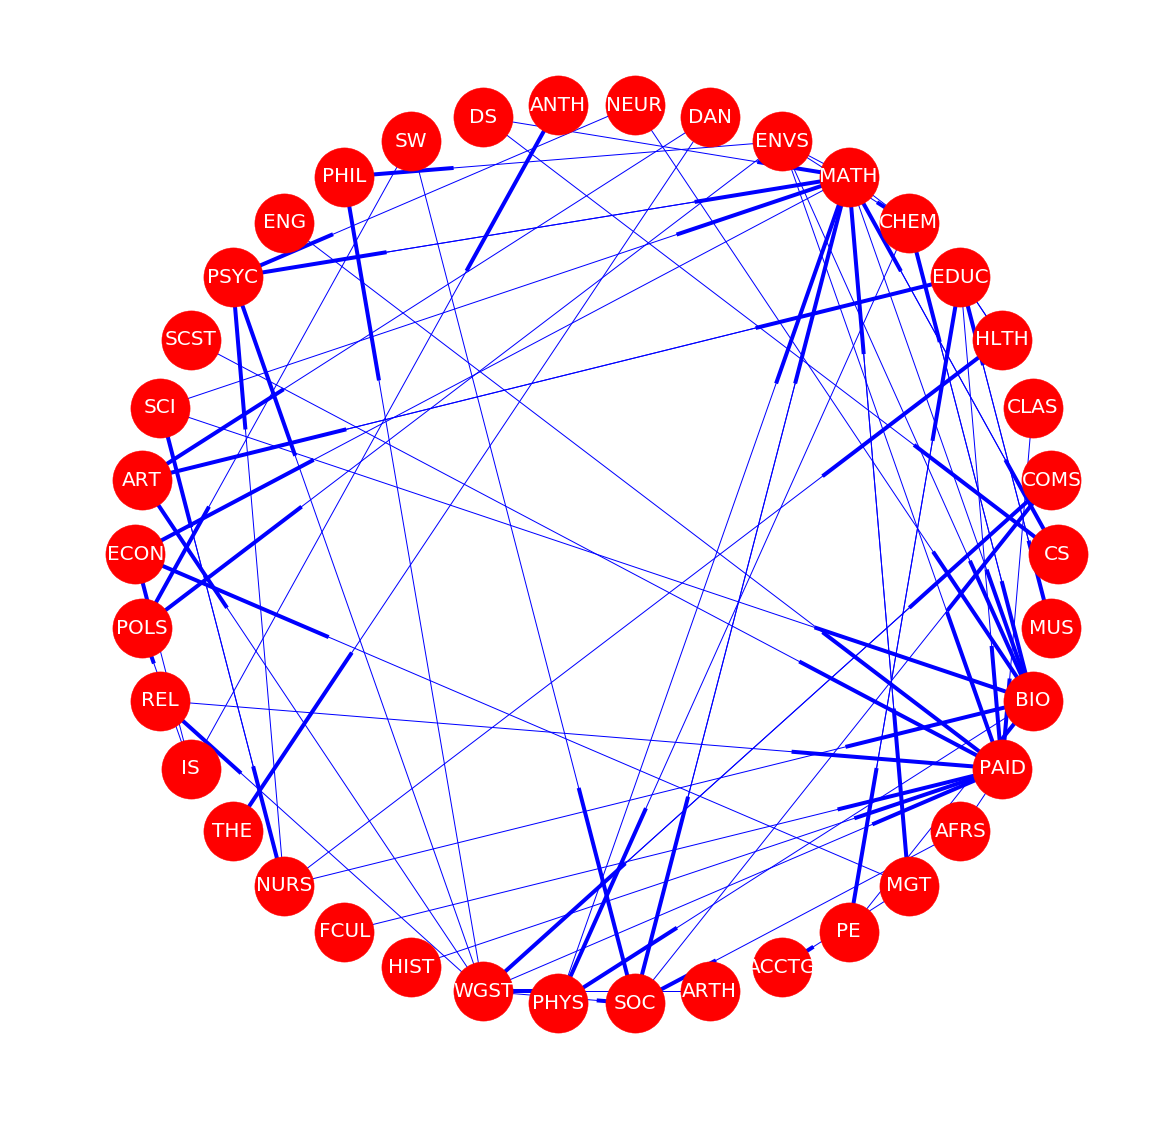

In [27]:
##Create graph to show relationship between prereqs and classes(the overlap)
##Ask Michael for help creating graph

g = nx.DiGraph()

g.add_nodes_from(df.dept_code)

for index, row in df.iterrows():
    g.add_edge(row['dept_code'], row['prereq_code'])

gfig,gax = plt.subplots(figsize=(20,20))
pos = nx.spring_layout(g,k=.3,scale=8.0,center=(0,0))
nx.draw(g,pos=nx.circular_layout(g),ax=gax,node_size=3500,with_labels=True,font_size=20, node_color='red', font_color='white', edge_color = "blue", iterations=5)

plt.show()